In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import time
from tqdm import tqdm
from path_explain.path_explainer_tf import PathExplainerTF

In [4]:
baseline = np.random.randn(1000, 10)
inputs = np.random.randn(50, 10)

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(10, dtype=tf.float32))
model.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [6]:
explainer = PathExplainerTF(model)

In [7]:
current_alphas = explainer._sample_alphas(num_samples=100, use_expectation=True)
interactions = explainer._single_interaction(inputs[0], baseline,
                              current_alphas, num_samples=100, batch_size=50,
                              use_expectation=True, output_index=None,
                              interaction_index=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [8]:
interactions = explainer.interactions(inputs, baseline,
                     batch_size=50, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=False, interaction_index=0)

In [9]:
interactions.shape

(50, 10)

In [10]:
batch_sizes = np.linspace(10, 200, 20).astype(int)
times = []
for batch_size in tqdm(batch_sizes):
    start_time = time.time()
    interactions = explainer.interactions(inputs, baseline,
                     batch_size=batch_size, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(inputs),
                     verbose=False, interaction_index=None)
    end_time = time.time()
    times.append(end_time - start_time)
    assert interactions.shape == (50, 10, 10), 'batch_size: {}'.format(batch_size)

100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


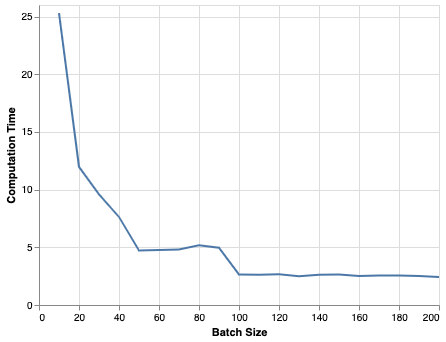

In [11]:
time_df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Computation Time': times
})
alt.Chart(time_df).mark_line().encode(
    alt.X('Batch Size:Q'),
    alt.Y('Computation Time:Q')
)